In [3]:
from ortools.linear_solver import pywraplp
#from ortools.sat.python import cp_model
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import pandas as pd
import time

In [4]:
def generateGanttChart(R,P,T,robotSchedule,startTimeSchedule,processTime):
    tasks_per_product = 3
    products = ['Product ' + str(i) for i in range(1, P+1)]
    robots = ['Robot ' + str(i) for i in range(1, R+1)]
    df = pd.DataFrame(columns=['Task', 'Robot', 'Product', 'Start', 'Finish'])
    task_id = 0
    colors = {'Product 1': 'red', 'Product 2': 'green', 'Product 3': 'blue', 'Product 4': 'orange', 'Product 5': 'purple','Product 6': 'black',}
    estimatedTime = sum(processTime,[])
    for product in products:
        for task_num in range(1, tasks_per_product+1):
            task_name = product + ' Task ' + str(task_num)
            robot = robotSchedule[task_id]+1
            start = startTimeSchedule[task_id]
            finish = startTimeSchedule[task_id]+estimatedTime[task_id]
            df.loc[task_id] = [task_name, robot, product, start, finish]
            task_id += 1
            
    df['task_duration'] = df['Finish'] - df['Start']
    print(df)
    # Create the Gantt chart
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, row in df.iterrows():
        ax.barh(y=row['Robot'], width=row['task_duration'], left=row['Start'], height=0.5, color=colors[row['Product']])
        ax.text(row['Start'], row['Robot'], row['Task'], ha='left', va='center', color='white', fontsize=8)
    
    # Set the x-axis and y-axis labels
    ax.set_title('Work Schedule')
    ax.set_xlabel('Hours')
    ax.set_ylabel('Robot')
    # Set the y-axis ticks
    ax.set_yticks(range(1, R+1))
    ax.set_yticklabels(robots)
    # Set the x-axis range to start at 0
    ax.set_xlim([0, df['Finish'].max()])
    
    # Show the Gantt chart
    plt.show()

In [5]:
# Declare the MILP sovler with the sat backend
solver = pywraplp.Solver.CreateSolver('SAT')
if not solver:
    print("No such solver")

In [6]:
# Define Constant Variables

# Assume that there are 4 robots and 5 products need to be processed.
# Each product process contains 3 tasks.
R=6
P=6
T=3

# Estimated Processing Time
E = [50,28,48]
changeTime = 40
# Transportation Time
L = [[0 for j in range(R)] for i in range(R)]

# Color
'''
color = [[1,1,2],[2,3,1],[3,2,2],[1,3,2],[3,1,3],
         [3,1,2],[1,2,1],[3,3,3],[2,3,1],[2,2,1],
         [1,1,2],[3,3,1],[1,2,3],[2,2,3],[3,3,2],
         [2,2,2],[1,1,3],[2,2,1],[2,3,1],[3,2,2]]
'''
color = [[1,1,2],[2,3,1],[3,2,2],[1,3,2],[3,1,3],
         [3,1,2]]

In [7]:
Row = 30
Column = 4
#Robots = [0,28,52,80,116,3,31,55,83,119]
Robots = [0,28,52,3,31,55]
#Map = np.arange(120).reshape(Row, Column)
for k in range(R):
    for w in range(R):
        if k==w:
            L[k][w]=0
        elif k==w-3 or k-3==w:
            L[k][w]=4
        elif k<=2 and w <=2:
            L[k][w]=np.abs((Robots[k]-Robots[w])/4)+1
        elif k<=2 and w>2:
            L[k][w]=np.abs((Robots[w-3]-Robots[k])/4)+1+4
        elif k>2 and w<=2:
            L[k][w]=np.abs((Robots[k-3]-Robots[w])/4)+1+4
        elif k>2 and w>2:
            L[k][w]=np.abs((Robots[k]-Robots[w])/4)+1

In [8]:
L

[[0, 8.0, 14.0, 4, 12.0, 18.0],
 [8.0, 0, 7.0, 12.0, 4, 11.0],
 [14.0, 7.0, 0, 18.0, 11.0, 4],
 [4, 12.0, 18.0, 0, 8.0, 14.0],
 [12.0, 4, 11.0, 8.0, 0, 7.0],
 [18.0, 11.0, 4, 14.0, 7.0, 0]]

In [9]:
# Define Decision Variables

# Waiting time of task ij
#w = [[solver.NumVar(0, solver.infinity(), f'w_{i}_{j}') for j in range(T)] for i in range(P)]

# Start time of task ij
s = [[solver.IntVar(0, solver.infinity(), f's_{i}_{j}') for j in range(T)] for i in range(P)]

# Task allocation. Equals 1 if t_{ij} is performed on robot k, 0 otherwise.
x = [[[solver.IntVar(0,1,f'x_{i}_{j}_{k}') for k in range(R)] for j in range(T)] for i in range(P)]

# Task sequence. Equals 1 if x_{ij} is performed before x_{gh} on robot k, 0 otherwise.
y = [[[[[solver.IntVar(0,1,f'y_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]

print('Number of variables =', solver.NumVariables())

Number of variables = 2070


In [10]:
# Add intermediate variables

# Two variables multiplication. xp = x[i][j][k]*x[g][h][k]
xp = [[[[[solver.IntVar(0,1,f'xp_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):
                        solver.Add(xp[i][j][g][h][k]<=x[i][j][k])
                        solver.Add(xp[i][j][g][h][k]<=x[g][h][k])
                        solver.Add(xp[i][j][g][h][k]>=x[i][j][k]+x[g][h][k]-1)

# Workload
v = [solver.IntVar(0,solver.infinity(),f'v_{k}') for k in range(R)]
c = [[[x[i][j][k]*E[j] for k in range(R)] for j in range(T)] for i in range(P)]
workLoad = [sum(sum([[c[i][j][k] for j in range(T)] for i in range(P)],[])) for k in range(R)]
workLoad_hat = sum(workLoad)/R
for k in range(R):
    solver.Add(v[k]>=workLoad[k]-workLoad_hat)
    solver.Add(v[k]>=workLoad_hat-workLoad[k])

# yij = y[i][j][g][h][k]*s[i][j]
# ygh = y[i][j][g][h][k]*s[g][h]
yij = [[[[[solver.IntVar(0,solver.infinity(),f'yij_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
ygh = [[[[[solver.IntVar(0,solver.infinity(),f'ygh_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):
                        solver.Add(yij[i][j][g][h][k]<=100000*y[i][j][g][h][k])
                        solver.Add(yij[i][j][g][h][k]<=s[i][j])
                        solver.Add(yij[i][j][g][h][k]>=s[i][j]-(1-y[i][j][g][h][k])*100000)
                        solver.Add(yij[i][j][g][h][k]>=0)

                        solver.Add(ygh[i][j][g][h][k]<=100000*y[i][j][g][h][k])
                        solver.Add(ygh[i][j][g][h][k]<=s[g][h])
                        solver.Add(ygh[i][j][g][h][k]>=s[g][h]-(1-y[i][j][g][h][k])*100000)
                        solver.Add(ygh[i][j][g][h][k]>=0) 
                    
# Robots of next task
f = [[[[solver.IntVar(0,1,f'f_{i}_{j}_{k}_{w}') for w in range(R)] for k in range(R)] for j in range(T-1)] for i in range(P)]
for i in range(P):
    for j in range(T-1):
        for k in range(R):
            for w in range(R):
                solver.Add(f[i][j][k][w]<=x[i][j][k])
                solver.Add(f[i][j][k][w]<=x[i][j+1][w])
                solver.Add(f[i][j][k][w]>=x[i][j][k]+x[i][j+1][w]-1)
                
# Equals 1 when previous task has different predefined color
penalty = [[[[solver.IntVar(0,1,f'penalty_{i}_{j}_{g}_{h}')  for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
for i in range(P):
    for j in range(T):
        for g in range(P):
            for h in range(T):
                penalty[i][j][g][h] = ((color[i][j] - color[g][h])!=0)
                
# Equals 1 when task ij is next to and before task gh
z = [[[[[solver.IntVar(0,1,f'z_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]

# Sum of how many tasks are performed before task gh
#pTasks = [[[solver.IntVar(0,solver.infinity(),f'pTasks_{i}_{j}_{k}') for k in range(R)] for j in range(T)] for i in range(P)]
pTasks = [[[0 for k in range(R)] for h in range(T)] for g in range(P)]
for k in range(R):
    for g in range(P):
        for h in range(T):
            solver.Add(sum(z[i][j][g][h][k] for i in range(P) for j in range(T)) == x[g][h][k])
            pTasks[g][h][k] = sum(y[i][j][g][h][k] for j in range(T) for i in range(P))

difference = [[[[[solver.IntVar(0,solver.infinity(),f'difference_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
maxFlag = [[[[[solver.IntVar(0,1,f'maxFlag_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
maxVaule = [[[[[solver.IntVar(0,solver.infinity(),f'maxVaule_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
for k in range(R):
    for g in range(P):
        for h in range(T):
            for i in range(P):
                for j in range(T):
                    if i==g and j==h:
                        solver.Add(difference[i][j][g][h][k] == 10)
                        solver.Add(z[i][j][g][h][k] == 0)
                    else:
                        solver.Add(maxVaule[i][j][g][h][k] >= (pTasks[g][h][k] - pTasks[i][j][k]))
                        solver.Add(maxVaule[i][j][g][h][k] >= -(pTasks[g][h][k] - pTasks[i][j][k]))
                        solver.Add(maxVaule[i][j][g][h][k] <= 10000*(1-maxFlag[i][j][g][h][k])+(pTasks[g][h][k] - pTasks[i][j][k]))
                        solver.Add(maxVaule[i][j][g][h][k] <= 10000*maxFlag[i][j][g][h][k]-(pTasks[g][h][k] - pTasks[i][j][k]))
                        solver.Add(difference[i][j][g][h][k] >= (pTasks[g][h][k] - pTasks[i][j][k]))
                        solver.Add(difference[i][j][g][h][k] >= -(pTasks[g][h][k] - pTasks[i][j][k]))
                        solver.Add(difference[i][j][g][h][k] <= maxVaule[i][j][g][h][k])
                        
# zDiff = z*difference
zDiff = [[[[[solver.IntVar(0,1,f'zDiff_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(R):
                for h in range(T):
                    if not(i==g and j==h):
                        solver.Add(zDiff[i][j][g][h][k] <= 10000 * z[i][j][g][h][k])
                        solver.Add(zDiff[i][j][g][h][k] <= difference[i][j][g][h][k])
                        solver.Add(zDiff[i][j][g][h][k] >= difference[i][j][g][h][k] -(1-z[i][j][g][h][k])*10000)
                        solver.Add(zDiff[i][j][g][h][k] >= 0)
                    else:
                        solver.Add(zDiff[i][j][g][h][k] == 1)
 # Add constraints for zDiff
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):
                        solver.Add(zDiff[i][j][g][h][k]>=0)
                        solver.Add(zDiff[i][j][g][h][k]<=1)
                        solver.Add(zDiff[i][j][g][h][k]<=y[i][j][g][h][k])
                        solver.Add(zDiff[i][j][g][h][k]==z[i][j][g][h][k])


           
 # colorChange = z*penalty
# Equals 1 when previous task performed on the same robot has different predefined color
colorChange = [[[[[solver.IntVar(0,1,f'colorChange_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):
                        solver.Add(colorChange[i][j][g][h][k] <= penalty[i][j][g][h])
                        solver.Add(colorChange[i][j][g][h][k] <= z[i][j][g][h][k])
                        solver.Add(colorChange[i][j][g][h][k] >= penalty[i][j][g][h]+z[i][j][g][h][k]-1)
                    else:
                        solver.Add(colorChange[i][j][g][h][k] == 0)
# yChange = y*colorChange

yChange = [[[[[solver.IntVar(0,1,f'yChange_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    solver.Add(yChange[i][j][g][h][k]<=y[i][j][g][h][k])
                    solver.Add(yChange[i][j][g][h][k]<=colorChange[i][j][g][h][k])
                    solver.Add(yChange[i][j][g][h][k]>=y[i][j][g][h][k]+colorChange[i][j][g][h][k]-1)
                        
# Penalty time
pt = [[[[[yChange[i][j][g][h][k]*changeTime for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
waitingTimeForChange = [[0 for h in range(T)] for g in range(P)]
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):
                        waitingTimeForChange[g][h] += pt[i][j][g][h][k]


In [11]:
# Define Objective functions

# Minimize the makespan
makespan = solver.IntVar(0, solver.infinity(), f'm')
for i in range(P):
    for j in range(T):
        solver.Add(makespan>=s[i][j]+E[2])
#solver.Minimize(cycleTime)
z1 = makespan

# Minimize the variance of workload
#solver.Minimize(1/R*sum(y))
z2 = sum(v)/R

# Weights of each objective functions
weights = [(1, 0), (0.9, 0.1), (0.8, 0.2), (0.7, 0.3), (0.6, 0.4), (0.5, 0.5), (0.4, 0.6), (0.3, 0.7), (0.2, 0.8), (0.1, 0.9)]

In [12]:
# Define constraints

# Constraints of convert workload function
c = [[[x[i][j][k]*E[j] for k in range(R)] for j in range(T)] for i in range(P)]
workLoad = [sum(sum([[c[i][j][k] for j in range(T)] for i in range(P)],[])) for k in range(R)]
workLoad_hat = sum(workLoad)/R
for k in range(R):
    solver.Add(v[k]>=workLoad[k]-workLoad_hat)
    solver.Add(v[k]>=workLoad_hat-workLoad[k])

# One task could be only processed on one robot
for i in range(P):
    for j in range(T):
            solver.Add(sum([x[i][j][k]*1 for k in range(R)])==1)

# Every Start time should bigger than zero
for i in range(P):
    for j in range(T):
        solver.Add(s[i][j]>=0)
    
# The order between two tasks of one product
routeLength = [[[[f[i][j][k][w]*L[k][w] for w in range(R)] for k in range(R)] for j in range(T-1)] for i in range(P)]
for k in range(R):
    for i in range(P):
        for j in range(T-1):
            solver.Add(s[i][j+1]-(s[i][j]+E[j]+waitingTimeForChange[i][j]+sum(sum(routeLength[i][j],[])))>=0)
              
# Completion condition
for i in range(P):
    solver.Add(sum(sum([[x[i][j][k]*1 for k in range(R)] for j in range(T)],[]))==3)
    
# Must at least one robot could run
for k in range(R):
    solver.Add(20-sum(sum([[x[i][j][k]*1 for j in range(T)] for i in range(P)],[]))>=0)

# Squency of two tasks
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):    
                        solver.Add(y[i][j][g][h][k]+y[g][h][i][j][k] == xp[i][j][g][h][k])
                    else:
                        solver.Add(y[i][j][g][h][k]==0)

# One robot only can process one task at the same time
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):
                        solver.Add(ygh[i][j][g][h][k]-yij[i][j][g][h][k]-y[i][j][g][h][k]*E[j]-yChange[i][j][g][h][k]*changeTime>=0)

In [13]:
print('Number of variables =', solver.NumVariables())

Number of variables = 22273


In [ ]:
start_time = time.time()
# Solve the problem.
print(f'Solving with {solver.SolverVersion()}')

objective = solver.Sum([5 * z1, 5 * z2])
solver.Minimize(objective)
status = solver.Solve()
end_time = time.time()
if status == pywraplp.Solver.OPTIMAL:
    print('Weight:', w, 'Solution:', solver.Objective().Value())
    '''
    for i in range(P):
        for j in range(T):
            for k in range(R):
                print('x =', x[i][j][k].solution_value())
    for i in range(P):
        for j in range(T):
            print('s =', s[i][j].solution_value())'''
else:
    print('No feasible solutions.')
running_time = end_time - start_time
print("The running time is:", running_time, "seconds.")

In [ ]:
for k in range(R):
    for i in range(P):
        for j in range(T):
            if x[i][j][k].solution_value() == 1:
                print(i,j,k)

0 0 0
0 1 0
1 2 0
5 1 0
0 2 1
3 0 1
4 1 1
1 1 2
2 0 2
5 2 2
2 2 3
5 0 3
3 1 4
4 0 4
4 2 4
1 0 5
2 1 5
3 2 5


In [ ]:
print(y[3][0][3][1][0].solution_value())
print(xp[3][0][3][1][0].solution_value())

0.0
0.0


In [ ]:
for k in range(R):
    for i in range(P):
        for j in range(T):
            if y[i][j][3][1][k].solution_value() == 1:
                print(i,j,k)

4 0 4


In [ ]:
productRobot = []
productStartTime = []
processTime = np.zeros((P,T), dtype=int)
for i in range(P):
    for j in range(T):
        productStartTime.append(s[i][j].solution_value())
        for k in range(R):
            if x[i][j][k].solution_value() == 1:
                productRobot.append(k)
            processTime[i][j] = E[j]

                Task  Robot    Product  Start  Finish  task_duration
0   Product 1 Task 1      1  Product 1    0.0    50.0           50.0
1   Product 1 Task 2      1  Product 1   50.0    78.0           28.0
2   Product 1 Task 3      2  Product 1  122.0   170.0           48.0
3   Product 2 Task 1      6  Product 2    0.0    50.0           50.0
4   Product 2 Task 2      3  Product 2   54.0    82.0           28.0
5   Product 2 Task 3      1  Product 2  106.0   154.0           48.0
6   Product 3 Task 1      3  Product 3    0.0    50.0           50.0
7   Product 3 Task 2      6  Product 3   54.0    82.0           28.0
8   Product 3 Task 3      4  Product 3   96.0   144.0           48.0
9   Product 4 Task 1      2  Product 4    0.0    50.0           50.0
10  Product 4 Task 2      5  Product 4   54.0    82.0           28.0
11  Product 4 Task 3      6  Product 4   89.0   137.0           48.0
12  Product 5 Task 1      5  Product 5    0.0    50.0           50.0
13  Product 5 Task 2      2  Produ

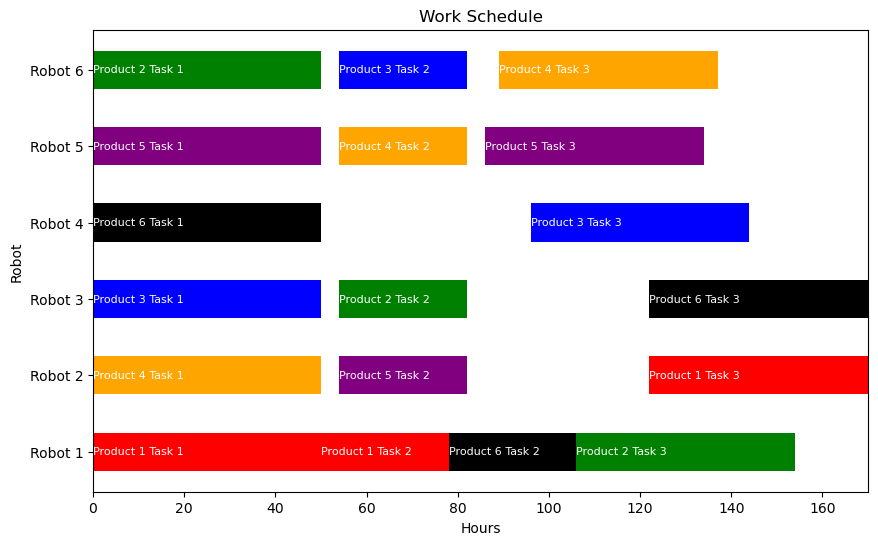

In [ ]:
generateGanttChart(R,P,T,productRobot,productStartTime,processTime.tolist())

In [ ]:
z[4][0][1][2][0].solution_value()

NameError: name 'z' is not defined

In [ ]:
difference[4][0][4][1][0].solution_value()

NameError: name 'difference' is not defined

In [ ]:
zDiff[4][0][4][1][0].solution_value()

0.0

In [ ]:
pTasks[2][2][0].solution_value()

0.0

In [ ]:
y[5][0][5][1][0].solution_value()

0.0

In [ ]:
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if z[i][j][g][h][k].solution_value()==1:
                        print(i,j,g,h,k)

0 0 0 1 0
0 1 5 1 0
4 0 0 0 0
5 1 1 2 0
3 0 4 1 1
4 0 3 0 1
4 1 0 2 1
1 1 5 2 2
2 0 1 1 2
3 2 2 0 2
4 1 5 0 3
5 0 2 2 3
3 1 4 2 4
4 0 3 1 4
4 1 4 0 4
1 0 2 1 5
2 1 3 2 5
3 0 1 0 5


In [ ]:
sum(z[i][j][3][2][1] for i in range(P) for j in range(T)).solution_value()

0.0

In [ ]:
for i in range(P):
    for j in range(T):
        for g in range(P):
            for h in range(T):
                if g==2 and h ==1:
                    if penalty[i][j][g][h]==1:
                        print(i,j)


0 0
0 1
1 1
1 2
2 0
3 0
3 1
4 0
4 1
4 2
5 0
5 1


In [ ]:
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if g==0 and h ==1:
                        if yChange[i][j][g][h][k].solution_value()==1:
                            print(i,j,k)